# CerealTimeKillersNet: Deep neural network for emotional states predictions from EEG data.

## Package setup

In [1]:
# Basic packages
import copy
import time
import random
import numpy as np
import pandas as pd

# Math packages
import math
from scipy.signal import spectrogram

# Plot packages
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset, SubsetRandomSampler, random_split

# ML Packages
from sklearn.model_selection import KFold


## Basic functions setup

In [2]:
# Set random seed
# Executing `set_seed(seed=seed)` you are setting the seed to ensure reproducibility.
# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

def set_seed(seed = None, seed_torch = True):
    if seed is None:
        seed = np.random.choice(2 ** 32)
    random.seed(seed)
    np.random.seed(seed)
    if seed_torch:
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

    print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


In [3]:
# @title Set device (GPU or CPU). Execute `set_device()` especially if torch modules used.
# inform the user if the notebook uses GPU or CPU.

def set_device():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        print("WARNING: For this notebook to perform best, "
            "if possible, in the menu under `Runtime` -> "
            "`Change runtime type.`  select `GPU` ")
    else:
        print("GPU is enabled in this notebook.")

    return device


In [4]:
# plot settings

def plot_loss_accuracy(train_loss, val_loss, test_loss, train_acc, val_acc, test_acc,
                       chance = 0.25):
    epochs = len(train_loss)
    
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.plot(list(range(epochs)), train_loss, label = 'Training')
    ax1.plot(list(range(epochs)), val_loss, label = 'Validation')
    ax1.plot(list(range(epochs)), test_loss, label = 'Testing')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Epoch vs Loss')
    ax1.legend()

    ax2.plot(list(range(epochs)), train_acc, label = 'Training')
    ax2.plot(list(range(epochs)), val_acc, label = 'Validation')
    ax2.plot(list(range(epochs)), test_acc, label = 'Testing')
    ax2.plot(list(range(epochs)), [chance * 100] * epochs, 'k--', label = 'Baseline')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_ylim([0, 100])
    ax2.set_title('Epoch vs Accuracy')
    ax2.legend()
    
    fig.set_size_inches(15.5, 5.5)
    plt.show()
    

In [5]:
# Norm
def calculate_frobenius_norm(model):
    norm = 0.0
    for param in model.parameters():
        norm += torch.sum(param ** 2)
    norm = norm ** 0.5
    return norm

def L1_norm(model):
    return sum(p.abs().sum() for p in model.parameters())

def L2_norm(model):
    return sum((p**2).sum() for p in model.parameters())


In [6]:
# Maximum label comparison for accracy

def maximum_extraction(tens, eplison = 1e-8):
    l_index = []
    for i in range(tens.shape[0]):
        label = tens[i].detach().numpy()
        l = []
        for j in range(len(label)):
            if label[j] > max(label) - eplison:
                l.append(j)
        l_index.append(l)
    return l_index
    
def maximum_comparison(list1, list2): # list2 is supposed to be real labels with multiple maximum values
    tot = 0
    for i in range(len(list1)):
        for j in range(len(list2[i])):
            list2[i][j] = round(list2[i][j])
        for j in range(len(list1[i])):
            if int(list1[i][j]) in list2[i]:
                tot += 1
                break
    return tot



## DataLoader setup

In [7]:
class CerealTimeKillersDataset(Dataset):
    """Spectrogram dataset for torch"""

    def __init__(self, df, transform = None):
        self.ori_dataframe = df
        self.transform = transform

    def __len__(self):
        return len(self.ori_dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        spectrogram = self.ori_dataframe.iloc[idx, -1]
        spectrogram = torch.tensor(spectrogram)
        if self.transform:
            spectrogram = self.transform(spectrogram)
        
        labels = self.ori_dataframe.iloc[idx, :-2]
        labels = torch.tensor(labels).type(torch.FloatTensor)
        if self.transform:
            labels = self.transform(labels)
        
        quadrants = self.ori_dataframe.iloc[idx, -2]
        quadrants = torch.tensor(quadrants).type(torch.FloatTensor)
        if self.transform:
            quadrants = self.transform(quadrants)
        
        return (spectrogram, labels, quadrants)
    

In [8]:
def get_specgram(df, labels, winlen = None, stride = 1, nperseg = 256, fs = 129):
    """
    Spectrogram from EEG data
    
    Inputs:
    df (pandas.DataFrame): EEG dataframe
    labels (CerealTimeKillersLabels): Electrode labels used for model prediction
    winlen (None/int): Time window for input sampling (for the whole timepoints, Default is None)
    stride (int): Temporal leap for input sampling (Default is 1)
    nperseg (int): N per seg of spectrogram (Default is 256)
    fs (int): Framerate of spectrogram (Default is 128)
    
    Returns:
    data (np.array): EEG data spectrogram with [samplepoint, frequency, time, channel]
    """
    
    # Load selected electrodes
    df = pd.DataFrame(df, columns = labels)
    d = np.array(df, dtype = float) # Switching from pandas to numpy array as this might be more comfortable for people
    
    full_spec = []
    for idx, d2 in enumerate(d.T):
        _, _, Sxx = spectrogram(d2, nperseg = nperseg, fs = fs)
        full_spec.append(Sxx)
        
    #DIMENSIONS OF FULL_SPEC WITHOUT WINDOWING (I.E. FULL WINDOWING)
    #DIMENSION 1: 1                      - FOR DIMENSIONAL CONSISTENCY
    #DIMENSION 2: CHANNELS  (DEFAULT=14) - MIGHT CHANGE (SO NOT REALLY DEFAULT BUT OK)
    #DIMENSION 3: FREQUENCY (DEFAULT=129)
    #DIMENSION 4: TIME      (DEFAULT=170) - MIGHT CHANGE AS WELL OK - WE ARE WORKING ON IT
    
    full_spec = np.vstack([full_spec])
    full_spec = np.moveaxis(full_spec, 0, 0)
    if winlen == None:
        return np.array([full_spec])
    
    i = 0
    full_spec_wind = []
    # STRICK THE FOLLOWING LOOP ON THE TIME (WINDOW) DIMENSION!
    while i * stride + winlen < full_spec.shape[2]:
        full_spec_wind.append(full_spec[: , : , i * stride : i * stride + winlen])
        i += 1
    
    #DIMENSIONS OF FULL_SPEC WITH WINDOWING    (FULL_SPEC_WIND) 
    #DIMENSION 1: SAMPLE    (NO DEFAULT - SORRY)
    #DIMENSION 2: CHANNELS  (DEFAULT=14) - MIGHT CHANGE (SO NOT REALLY DEFAULT BUT OK)
    #DIMENSION 3: FREQUENCY (DEFAULT=129)
    #DIMENSION 4: WINDOWS   (DEFAULT=1)
    
    full_spec_wind = np.array(full_spec_wind)
    return full_spec_wind


In [9]:
def CerealTimeKillersDataLoader(dir_base, label_class, label_range, 
                                dataset_mix = True, 
                                winlen = None, stride = 1, nperseg = 256, fs = 129,
                                transform = None):
    """
    Cereal Time Killers Data Loader
    
    Inputs:
    dir_base (str): Working space dictionary
    label_class (CerealTimeKillersLabels): Labels used for model prediction
    label_range (1*2 list): The [min, max] of emotional states for transformation
    dataset_mix (bool): Whether to allow between-subject and between-game dataset mixture (Default is True)
    winlen (None/int): Time window for input sampling (for the whole timepoints, Default is None)
    stride (int): Temporal leap for input sampling (Default is 1)
    nperseg (int): N per seg of spectrogram (Default is 256)
    fs (int): Framerate of spectrogram (Default is 128)
    transform (torchvision.transforms.transforms.Compose): Torch transormfation (Default is None)
    
    Returns:
    FullDataset (CerealTimeKillersDatase list): full data with EEG spectrogram and fixed labels (information and/or emotional states) in CerealTimeKillersLabels
        FullDataset[i]: ith datapoint of [spectrogram, labels, quadrants]
    DataSize (Tuple): Data size for single point as (Input size as tuple, Output size as int)
    ExpIndex (pandas.DataFrame): Corresponsing ['subject', 'game'] index with shared row indices from FullDataset
    """
    
    specgram_name = 'full_specgram_1'
    
    # Load label & EEG data
    labels_df = pd.read_csv(f'{dir_base}GameLabels.csv')
    spec_df = pd.DataFrame(columns = label_class.fixed + ['emotion', specgram_name], dtype = float)
    index_df = pd.DataFrame(columns = ['subject', 'game'], dtype = int)
    
    # Create spectrogram dataframe
    for idx in range(labels_df.shape[0]): 
        
        # Load info and fixed labels
        subject = int(labels_df['subject'].iloc[idx])
        game = int(labels_df['game'].iloc[idx])
        fixed_labels = labels_df[label_class.fixed].iloc[idx]
        fixed_labels = list(np.array(np.array(fixed_labels, dtype = 'float') - label_range[0]) / (label_range[1] - label_range[0]))
        
        # Maximum quadrant emotion labels
        quadrant_labels = labels_df[label_class.quadrant].iloc[idx]
        quadrant_labels = list(np.array(quadrant_labels, dtype = 'float'))
        
        # You can also just paste in the Directory of the csv file - on windows you may have to change the slash direction
        DirComb = f'{dir_base}GAMEEMO/(S{str(subject).zfill(2)})/Preprocessed EEG Data/.csv format/S{str(subject).zfill(2)}G{str(game)}AllChannels.csv'
        CsvSpec = pd.read_csv(DirComb, sep = ',')
        
        # Get EEG spectrogram
        spec_EEG = get_specgram(CsvSpec, label_class.electrode, 
                                winlen = winlen, stride = stride, nperseg = nperseg, fs = fs)
        
        # Add new data to dataframe
        new_spec_list, new_index_list = list(), list()
        if dataset_mix:
            for i in range(spec_EEG.shape[0]):
                new_spec_list.append(fixed_labels + [quadrant_labels] + [spec_EEG[i]])
                new_index_list.append([subject, game])
        else:
            new_spec_list.append(fixed_labels + [quadrant_labels] + [spec_EEG])
            new_index_list.append([subject, game])
        
        # Update dataframe
        new_spec_df = pd.DataFrame(new_spec_list, columns = label_class.fixed + ['emotion', specgram_name], dtype = float)
        spec_df = pd.concat([spec_df, new_spec_df], ignore_index = True)    
        new_index_df = pd.DataFrame(new_index_list, columns = ['subject', 'game'], dtype = int)
        
        index_df = pd.concat([index_df, new_index_df], ignore_index = True)
    
    # Output
    final_df = CerealTimeKillersDataset(df = spec_df, transform = transform)
    data_size = (tuple(final_df[0][0].shape), tuple(final_df[0][1].shape))

    return final_df, data_size, index_df


In [10]:
def CerealTimeKillersDataSplitter(full_dataset, exp_index, 
                                  allocation_test = None, 
                                  test_ratio = 0.2, target_test = [], k_folds = 10, 
                                  batch_size_train = 16, batch_size_test = 32, 
                                  seed = 0, generator = None):
    """
    Cereal Time Killers Data Splitter
    
    Inputs:
    full_dataset (CerealTimeKillersDataset): full data with EEG spectrogram and experimental labels (information and emotional states)
        full_dataset[i]: ith data for a specific subject and game of {'spectrogram': spectrogram, 'labels': labels}
    exp_index (pandas.DataFrame): Corresponsing ['subject', 'game', 'emotion'] with shared row indices from full_dataset
    allocation_test (None/str): Which to be based for allocating testing dataset (Default is None) # [None, 'subject', 'game']
    test_ratio (float) Proportion of data used for testing when Allocation_test == None (Default is 0.2)
    target_test (list): Int list for allocating corresponding game/subject as testing dataset when Allocation_test != None (Default is [])
    k_folds (int): Number for K-folds for training vs validation (Default is 10)
    batch_size_train (int): Number of examples per minibatch during training (Default is 16)
    batch_size_test (int): Number of examples per minibatch during validation/testing (Default is 1)
    seed (int): Random seed for reproducibility (Default is 0)
    generator (torch._C.Generator): Torch generator for reproducibility (Default is None)
    
    Returns:
    SplittedDataset (dict): Full dataset splitted in {'train': training, 'val': validation, 'test': testing}
        SplittedDataset['train'][fold].dataset (CerealTimeKillersDataset): Training dataset in nth fold
        SplittedDataset['val'][fold].dataset (CerealTimeKillersDataset): Validation dataset in nth fold
        SplittedDataset['test'].dataset (CerealTimeKillersDataset): Testing dataset outside folds
    SplittedDataLength (dict): Length of dataset in {'train': training, 'val': validation, 'test': testing}
    """
    
    # Split into train/val and test datasets
    train_set_index, test_set_index = list(), list()
    if allocation_test == None:
        test_size = int(test_ratio * len(full_dataset))
        train_size = len(full_dataset) - test_size
        train_set_orig, test_set_orig = random_split(full_dataset, 
                                                     [train_size, test_size], 
                                                     generator = generator)
    elif (allocation_test == 'subject') or (allocation_test == 'game'):
        train_set_index = exp_index[~exp_index[allocation_test].isin(target_test)].index.tolist()
        test_set_index = exp_index[exp_index[allocation_test].isin(target_test)].index.tolist()
        train_set_orig = Subset(full_dataset, train_set_index)
        test_set_orig = Subset(full_dataset, test_set_index)
    else:
        print("Allocate testing dataset based on one of the 'Subject', 'Game', or None.")
        return None
    
    # Test dataset loader
    test_loader = DataLoader(test_set_orig,
                             batch_size = batch_size_test,
                             num_workers = 0,
                             generator = g_seed)
    
    # K-fold Cross Validator
    train_loader, val_loader = [[]] * k_folds, [[]] * k_folds
    kfold = KFold(n_splits = k_folds, shuffle = True, random_state = seed)
    for fold, (train_i, val_i) in enumerate(kfold.split(train_set_orig)):
        
        # Sample train/test dataset from indices
        train_sampler = SubsetRandomSampler(train_i, generator = g_seed)
        val_sampler = SubsetRandomSampler(val_i, generator = g_seed)
        
        # Train/Validation dataset loader
        train_loader[fold] = DataLoader(train_set_orig,
                                        sampler = train_sampler,
                                        batch_size = batch_size_train,
                                        num_workers = 0,
                                        generator = generator)
        val_loader[fold] = DataLoader(train_set_orig,
                                      sampler = val_sampler,
                                      batch_size = batch_size_test,
                                      num_workers = 0,
                                      generator = generator)
    
    # return datasplitter
    data_loader = {'train': train_loader, 'val': val_loader, 'test': test_loader}
    data_length = {'train': len(train_sampler), 'val': len(val_sampler), 'test': len(test_set_orig)}
    return data_loader, data_length


## Neural network setup

In [11]:
def train(args, model, train_loader, optimizer = None, criterion = nn.MSELoss()):
    
    model.train()

    for (data, target, quadrant) in train_loader:
        data, target = data.type(torch.float).to(args['device']), target.type(torch.float).to(args['device'])
        optimizer.zero_grad() 
        output = model(data)
        
        loss = criterion(output, target) + args['l1'] * L1_norm(model) + args['l2'] * L2_norm(model)
        loss.backward()
        
        optimizer.step()


In [12]:
def test(args, label, model, test_loader, criterion = nn.MSELoss()):
    
    model.eval()
    
    global Is_2D_to_quardrant_emotion
    eval_loss = 0.0
    acc = 0.0
    total = 0
    with torch.no_grad():
        for (data, target, quadrant) in test_loader:
            data = data.type(torch.float).to(args['device'])
            target = target.type(torch.float).to(args['device'])
            quadrant = quadrant.type(torch.float).to(args['device'])
            output = model(data)
            
            loss = criterion(output, target)
            eval_loss += loss.item()
            
            if not Is_2D_to_quardrant_emotion:
                predicted = maximum_extraction(output)
                labels = maximum_extraction(target)
            else:
                predicted = emotion_transformation(output, label)
                # labels = maximum_extraction(quadrant)
                labels = emotion_transformation(target, label)
            acc += maximum_comparison(predicted, labels)
            total += target.size(0)
            
    return eval_loss / len(test_loader), acc * 100 / total


In [13]:
def simulation(args, label, model, train_loader, val_loader, test_loader, 
               optimizer = None, criterion = nn.MSELoss()):
    
    model = model.to(args['device'])
    
    val_loss_list, train_loss_list, test_loss_list = [], [], []
    val_acc_list, train_acc_list, test_acc_list = [], [], []
    param_norm_list = []
    best_loss = 100
    for epoch in tqdm(range(args['epochs'])):
        
        train(args, model, train_loader, optimizer = optimizer, criterion = criterion)
        param_norm = calculate_frobenius_norm(model)
        
        train_loss, train_acc = test(args, label, model, train_loader, criterion = criterion)
        val_loss, val_acc = test(args, label, model, val_loader, criterion = criterion)
        test_loss, test_acc = test(args, label, model, test_loader, criterion = criterion)
        
        if (val_loss < best_loss) or (epoch == 0):
            best_loss = val_loss
            best_epoch = epoch
            best_model = copy.deepcopy(model)
            wait = 0
        else:
            wait += 1
        
        train_loss_list.append(train_loss)
        val_loss_list.append(val_loss)
        test_loss_list.append(test_loss)
        train_acc_list.append(train_acc)
        val_acc_list.append(val_acc)
        test_acc_list.append(test_acc)
        param_norm_list.append(param_norm)
        
        if wait > args['patience']:
            print('Early stopped on epoch', best_epoch)
            break
        
        if ((epoch + 1) % 10 == 0) or (epoch + 1 == args['epochs']):
            print('-----Epoch ', epoch + 1, '/', args['epochs'])
            print('Train/Val/TEST MSE:', train_loss, val_loss, test_loss)
            print('Train/Val/TEST Accuracy:', train_acc, val_acc, test_acc)
    
    plot_loss_accuracy(train_loss_list, val_loss_list, test_loss_list, 
                       train_acc_list, val_acc_list, test_acc_list)

    return (train_loss_list, val_loss_list, test_loss_list), (train_acc_list, val_acc_list, test_acc_list), param_norm_list, best_model, best_epoch


In [14]:
# Main function of model simulation
def CerealTimeKillersModelSimulator(args, label,
                                    TrainDataLoader, ValDataLoader, TestDataLoader, DataSize,
                                    K_fold_train = False, k_folds = 1):
    
    N_FOLD = k_folds if K_fold_train else 1
    loss, acc, param, models = [], [], [], []
    
    for fold in range(N_FOLD):
        print('\n%d/%d Fold' % (fold + 1, N_FOLD))
        print('----------------------------')
    
        model, optimizer, criterion = CerealTimeKillersModelGenerator(args, size = DataSize)
        loss_list, acc_list, param_norm_list, trained_model, epoch = simulation(args, label, model,
                                                                                TrainDataLoader[fold],
                                                                                ValDataLoader[fold],
                                                                                TestDataLoader,
                                                                                optimizer = optimizer,
                                                                                criterion = criterion)
    
        loss_list, acc_list = np.array(loss_list), np.array(acc_list)
        loss.append([loss_list[0, epoch], loss_list[1, epoch], loss_list[2, epoch]])
        acc.append([acc_list[0, epoch], acc_list[1, epoch], acc_list[2, epoch]])
        param.append(param_norm_list[epoch])
        models.append(trained_model)
        
        print('Train/Val/Test Final MSE:', list(loss[-1]))
        print('Train/Val/Test Maximum Accuracy:', list(acc[-1]))
    
    return loss, acc, param, models


## Model settings - Change models here!

In [15]:
class CTKNet(nn.Module):
    def __init__(self, input_shape, out_size):

        super(CTKNet, self).__init__()
        
        # Model hyperparametres (layer by layer)
        conv_channel = [5, 5]
        conv_kernel = [3, 10]
        pool_kernel = [1, 1]
        fc_unit = [64]
        drop_out = [0.5]
        
        # Hidden layers
        img_size = np.array(input_shape[1:])
        
        self.conv1 = nn.Conv2d(in_channels = input_shape[0], out_channels = conv_channel[0], kernel_size = conv_kernel[0])
        # self.bn1 = nn.BatchNorm2d(conv_channel[0])
        self.pool1 = nn.MaxPool2d(kernel_size = pool_kernel[0])
        img_size = np.floor((img_size - conv_kernel[0] + 1.0) / pool_kernel[0])
        
        self.conv2 = nn.Conv2d(in_channels = conv_channel[0], out_channels = conv_channel[1], kernel_size = conv_kernel[1])
        # self.bn2 = nn.BatchNorm2d(conv_channel[1])
        self.pool2 = nn.MaxPool2d(kernel_size = pool_kernel[1])
        img_size = np.floor((img_size - conv_kernel[1] + 1.0) / pool_kernel[1])
        
        fc_input_size = int(np.prod(img_size) * conv_channel[1])
        
        self.fc1 = nn.Linear(in_features = fc_input_size, out_features = fc_unit[0])
        self.drop1 = nn.Dropout(drop_out[0])
        
        self.fc2 = nn.Linear(in_features = fc_unit[0], out_features = out_size[0])
    

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        # x = self.bn1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = F.relu(x)
        # x = self.bn2(x)
        x = self.pool2(x)
        
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.drop1(x)
        x = F.relu(x)
        
        x = self.fc2(x)
        x = torch.sigmoid(x)
        
        return x


In [16]:
class YourNet(nn.Module):
    def __init__(self, input_shape, out_size):

        super(YourNet, self).__init__()
        
        # Model hyperparametres (layer by layer)
        ...
        
        # Hidden layers
        ...

    def forward(self, x):
        ...
        
        return x


In [17]:
# Model selection function
def CerealTimeKillersModelGenerator(args, size):
    
    model = CTKNet(input_shape = size[0], out_size = size[1])
    optimizer = optim.SGD(model.parameters(), lr = args['lr'], momentum = args['momentum'])
    criterion = nn.MSELoss()
    
    return model, optimizer, criterion


## Input settings - Change hypermatres here!

In [18]:
class CerealTimeKillersLabels:
    """
    Select labels for model prediction
    Labels used for prediction: info + electrode --> prediction
    CHANGE these with necessity before loading data
    """
    
    # ['subject', 'game', 'gender', 'age', 'disturbance', 'experience', 'memory']
    info = []
        
    # ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
    electrode = ['AF3', 'AF4', 'F3', 'F4', 'F7', 'F8', 'FC5', 'FC6', 'O1', 'O2', 'P7', 'P8', 'T7', 'T8']
        
    # ['satisfied', 'boring', 'horrible', 'calm', 'funny', 'valence', 'arousal']
    prediction = ['boring', 'horrible', 'calm', 'funny']
    # prediction = ['valence', 'arousal']
    
    # Quadrant emotions (applied after predicting valence/arousal)
    quadrant = ['boring', 'horrible', 'calm', 'funny']
    
    # Fixed variables
    fixed = info + prediction
    
    # Summarise labels for model
    label = info + electrode + prediction


# 2D emotions ['valence', 'arousal'] to 4 quadrant emotions ['boring', 'horrible', 'calm', 'funny']
def emotion_transformation(pred, label, c = 0.5):
    # Quadrant I:   ('valence' >= c, 'arousal' >= c) --> 'funny' 
    # Quadrant II:  ('valence' >= c, 'arousal' <= c) --> 'calm'
    # Quadrant III: ('valence' <= c, 'arousal' <= c) --> 'boring'
    # Quadrant IV:  ('valence' <= c, 'arousal' >= c) --> 'horrible'
    ans = []
    pred = pred.detach().numpy()
    i, j = 0, 1 # index of 'valence' and 'arousal' in CerealTimeKillersLabels.prediction
    
    for k in range(pred.shape[0]): # batch
        anss = []
        if (pred[k, i] >= c) and (pred[k, j] >= c):
            anss.append(3) # index of 'funny' in CerealTimeKillersLabels.quadrant
        if (pred[k, i] >= c) and (pred[k, j] <= c):
            anss.append(2) # index of 'calm' in CerealTimeKillersLabels.quadrant
        if (pred[k, i] <= c) and (pred[k, j] >= c):
            anss.append(1) # index of 'horrible' in CerealTimeKillersLabels.quadrant
        if (pred[k, i] <= c) and (pred[k, j] <= c):
            anss.append(0) # index of 'boring' in CerealTimeKillersLabels.quadrant
        ans.append(anss)
        
    return ans


In [19]:
# General settings
workspace_dir = '' # Workspace directionary
LabelRange = [1, 10] # The [min, max] of emotional states for transformation

# Whether to allow between-window dataset mixture
# SET TO FALSE FOR 4-DIMENSIONAL INPUT WHEN USING RNN
Is_between_subject = True # Default is True for 3-dimensional input

# Whether to transform 2D emotion  (valence/arousal) to 4 quardrant emotions ()
Is_2D_to_quardrant_emotion = False # Default is False

# Which to be based for allocating testing dataset (only when Is_between_subject = True)
Allocation_test = None # [None, 'subject', 'game'] # Default is None
test_ratio = 0.2 # Proportion of data used for testing when Allocation_test == None
Target_test = [25, 26, 27] # Int list for allocating corresponding game/subject as testing dataset when Allocation_test != None

# Model structural settings
N_inputtime = None # Time window for input sampling (Default is None for the whole timepoints)
N_stridetime = N_inputtime # Temporal leap for input sampling when N_inputtime != None
N_perseg = 256 # N per seg of spectrogram
N_framerate = 128 # Framerate of spectrogram

# Model training settings
batch_size_train = 16 # Number of examples per minibatch during training
batch_size_test = 1 # Number of examples per minibatch during validation/testing
k_folds = 5 # Number for K-folds for training vs validation (validation is 1/k_folds of the train/val set)
K_fold_train = True # Whether enable the full K-fold cross-validation for training (if False, validate only once)

# Model hypermparametres
args = {
    'epochs': 150,
    'lr': 5e-4,
    'momentum': 0.99,
    'l1': 1e-3,
    'l2': 1e-3,
    'patience': 30,
    'device': set_device(),
}
print('Current device:', args['device'])

# Set random seed for reproducibility
SEED = 2021
set_seed(seed = SEED)
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

# Torch-based data transformation
data_transform = None


Current device: cpu
Random seed 2021 has been set.


## MAIN CODE

In [20]:
# Implement Dataloader
FullDataset, DataSize, ExpIndex = CerealTimeKillersDataLoader(dir_base = workspace_dir,
                                                              label_class = CerealTimeKillersLabels,
                                                              label_range = LabelRange,
                                                              dataset_mix = Is_between_subject,
                                                              winlen = N_inputtime,
                                                              stride = N_stridetime,
                                                              nperseg = N_perseg,
                                                              fs = N_framerate,
                                                              transform = data_transform)

# Implement DataSplitter
SplittedDataset, SplittedDataLength = CerealTimeKillersDataSplitter(FullDataset, 
                                                                    exp_index = ExpIndex, 
                                                                    allocation_test = Allocation_test,
                                                                    test_ratio = test_ratio,
                                                                    target_test = Target_test,
                                                                    k_folds = k_folds,
                                                                    batch_size_train = batch_size_train,
                                                                    batch_size_test = batch_size_test,
                                                                    seed = SEED,
                                                                    generator = g_seed)

# Load Splited data
(TrainDataLoader, ValDataLoader, TestDataLoader) = (SplittedDataset['train'],
                                                    SplittedDataset['val'],
                                                    SplittedDataset['test'])

# Show data size
print('Dataset length:', SplittedDataLength)
print('Input shape: [channel, frequency, time]')
print('Single input data size:', DataSize[0])
print('Single output data size:', DataSize[1])


Dataset length: {'train': 70, 'val': 17, 'test': 21}
Input shape: [channel, frequency, time]
Single input data size: (14, 129, 170)
Single output data size: (4,)


In [21]:
# Model selection
model, optimizer, criterion = CerealTimeKillersModelGenerator(args, size = DataSize)
print(model)
summary(model, DataSize[0])


CTKNet(
  (conv1): Conv2d(14, 5, kernel_size=(3, 3), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 5, kernel_size=(10, 10), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=93810, out_features=64, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=64, out_features=4, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 5, 127, 168]             635
         MaxPool2d-2          [-1, 5, 127, 168]               0
            Conv2d-3          [-1, 5, 118, 159]           2,505
         MaxPool2d-4          [-1, 5, 118, 159]               0
            Linear-5                   [-1, 64]       6,003,904
           Dropout-6                   [-1, 64]               0
            Linear-7 

/Users/chronowanderer/.local/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



1/5 Fold
----------------------------


-----Epoch  10 / 150
Train/Val/TEST MSE: 0.06328072249889374 0.08634448162693945 0.1094163917892036
Train/Val/TEST Accuracy: 79.71014492753623 72.22222222222223 47.61904761904762
-----Epoch  20 / 150
Train/Val/TEST MSE: 0.027777369879186154 0.0910043211446868 0.0834769228295911
Train/Val/TEST Accuracy: 78.26086956521739 55.55555555555556 57.142857142857146
-----Epoch  30 / 150
Train/Val/TEST MSE: 0.02410228122025728 0.08045238194366296 0.07772406751090395
Train/Val/TEST Accuracy: 88.40579710144928 66.66666666666667 61.904761904761905
-----Epoch  40 / 150
Train/Val/TEST MSE: 0.01775848902761936 0.09157713231009741 0.07665075714300786
Train/Val/TEST Accuracy: 86.95652173913044 66.66666666666667 66.66666666666667
-----Epoch  50 / 150
Train/Val/TEST MSE: 0.01337524801492691 0.07473848703213865 0.06989621112699665
Train/Val/TEST Accuracy: 94.20289855072464 77.77777777777777 66.66666666666667
-----Epoch  60 / 150
Train/Val/TEST MSE: 0.012111460231244564 0.06784645198947853 0.0720068185723253

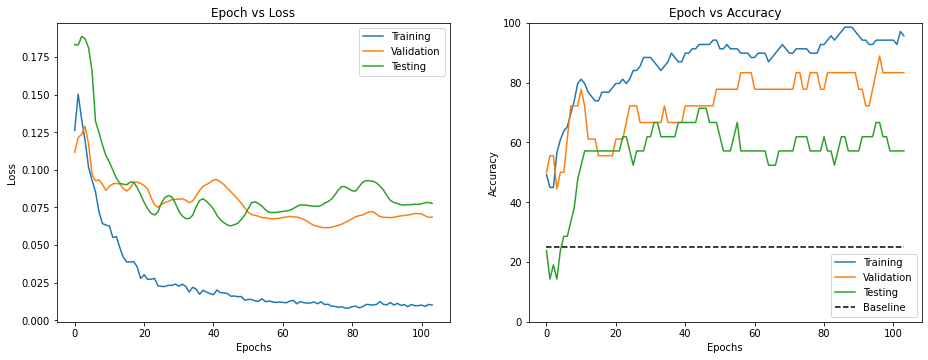

Train/Val/Test Final MSE: [0.010499020852148534, 0.061547394583208695, 0.07778006228840068]
Train/Val/Test Maximum Accuracy: [91.30434782608695, 83.33333333333333, 61.904761904761905]

2/5 Fold
----------------------------


-----Epoch  10 / 150
Train/Val/TEST MSE: 0.06623069271445274 0.09089727973979381 0.11857118901042711
Train/Val/TEST Accuracy: 85.5072463768116 38.888888888888886 47.61904761904762
-----Epoch  20 / 150
Train/Val/TEST MSE: 0.029478493332862853 0.11168616885940234 0.11164760223722883
Train/Val/TEST Accuracy: 97.10144927536231 44.44444444444444 38.095238095238095
-----Epoch  30 / 150
Train/Val/TEST MSE: 0.02566469870507717 0.0941433920007613 0.11857235892897561
Train/Val/TEST Accuracy: 95.65217391304348 50.0 52.38095238095238
Early stopped on epoch 7



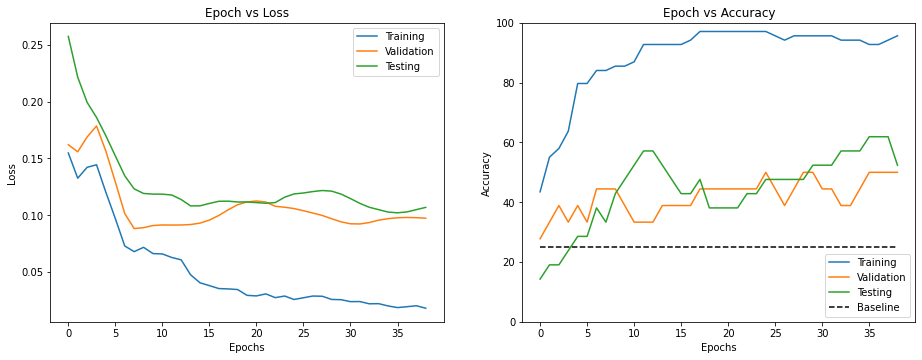

Train/Val/Test Final MSE: [0.06793583482503891, 0.08824312159170707, 0.12317950983664819]
Train/Val/Test Maximum Accuracy: [84.05797101449275, 44.44444444444444, 33.333333333333336]

3/5 Fold
----------------------------


-----Epoch  10 / 150
Train/Val/TEST MSE: 0.06402265280485153 0.11623591491404701 0.1283140108876285
Train/Val/TEST Accuracy: 70.0 52.94117647058823 19.047619047619047
-----Epoch  20 / 150
Train/Val/TEST MSE: 0.03516198173165321 0.08804981191368665 0.11147597296873019
Train/Val/TEST Accuracy: 88.57142857142857 64.70588235294117 52.38095238095238
-----Epoch  30 / 150
Train/Val/TEST MSE: 0.01998189715668559 0.07151533411267925 0.10948441452568486
Train/Val/TEST Accuracy: 92.85714285714286 64.70588235294117 47.61904761904762
-----Epoch  40 / 150
Train/Val/TEST MSE: 0.01816381011158228 0.08194505515070084 0.1173289841750548
Train/Val/TEST Accuracy: 91.42857142857143 58.8235294117647 47.61904761904762
-----Epoch  50 / 150
Train/Val/TEST MSE: 0.013239678367972374 0.07874594226150829 0.10817425511777401
Train/Val/TEST Accuracy: 92.85714285714286 58.8235294117647 52.38095238095238
Early stopped on epoch 27



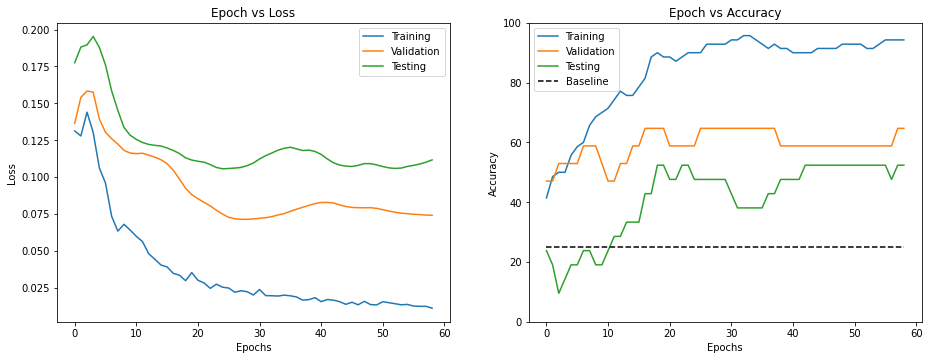

Train/Val/Test Final MSE: [0.022914897836744785, 0.07129014031413723, 0.10648868201921384]
Train/Val/Test Maximum Accuracy: [92.85714285714286, 64.70588235294117, 47.61904761904762]

4/5 Fold
----------------------------


-----Epoch  10 / 150
Train/Val/TEST MSE: 0.05948261171579361 0.1315810930750826 0.12137868308595248
Train/Val/TEST Accuracy: 77.14285714285714 41.1764705882353 28.571428571428573
-----Epoch  20 / 150
Train/Val/TEST MSE: 0.03197233006358147 0.09562033946242403 0.1007272479168716
Train/Val/TEST Accuracy: 91.42857142857143 41.1764705882353 47.61904761904762
-----Epoch  30 / 150
Train/Val/TEST MSE: 0.021571085229516028 0.08973053859218079 0.09653159895069188
Train/Val/TEST Accuracy: 95.71428571428571 47.05882352941177 52.38095238095238
-----Epoch  40 / 150
Train/Val/TEST MSE: 0.015710209030658007 0.08899894148549613 0.09817177280118423
Train/Val/TEST Accuracy: 94.28571428571429 52.94117647058823 52.38095238095238
-----Epoch  50 / 150
Train/Val/TEST MSE: 0.012813669070601464 0.09521726485999192 0.10349710560625508
Train/Val/TEST Accuracy: 97.14285714285714 58.8235294117647 52.38095238095238
Early stopped on epoch 24



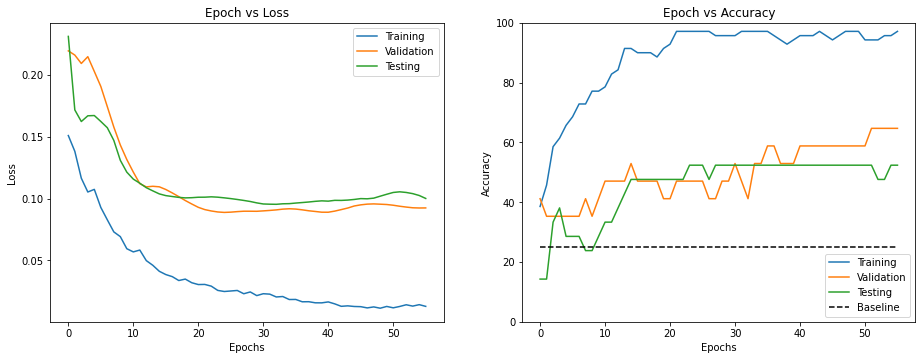

Train/Val/Test Final MSE: [0.024891730211675168, 0.08882283452240859, 0.10059945835244088]
Train/Val/Test Maximum Accuracy: [97.14285714285714, 47.05882352941177, 52.38095238095238]

5/5 Fold
----------------------------


-----Epoch  10 / 150
Train/Val/TEST MSE: 0.04329277127981186 0.10732289184542264 0.10474081989377737
Train/Val/TEST Accuracy: 77.14285714285714 52.94117647058823 42.857142857142854
-----Epoch  20 / 150
Train/Val/TEST MSE: 0.019870343431830407 0.08155690199312042 0.09769494867040998
Train/Val/TEST Accuracy: 81.42857142857143 58.8235294117647 42.857142857142854
-----Epoch  30 / 150
Train/Val/TEST MSE: 0.020043037086725234 0.08355442637248951 0.09242690741528004
Train/Val/TEST Accuracy: 87.14285714285714 58.8235294117647 42.857142857142854
-----Epoch  40 / 150
Train/Val/TEST MSE: 0.01575657483190298 0.07060360733200521 0.09097098451595576
Train/Val/TEST Accuracy: 85.71428571428571 70.58823529411765 52.38095238095238
-----Epoch  50 / 150
Train/Val/TEST MSE: 0.012211509980261326 0.06908556808005362 0.08525484118477575
Train/Val/TEST Accuracy: 92.85714285714286 88.23529411764706 57.142857142857146
-----Epoch  60 / 150
Train/Val/TEST MSE: 0.010378721635788679 0.0661036931526135 0.084856270723

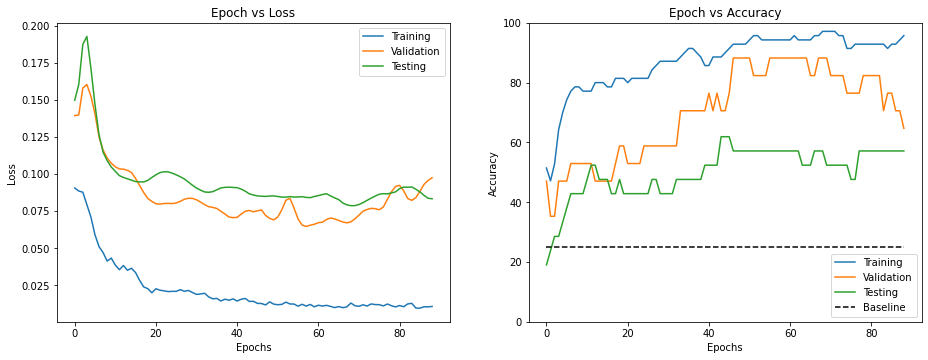

Train/Val/Test Final MSE: [0.010862484108656645, 0.06464962743441849, 0.0842504615762404]
Train/Val/Test Maximum Accuracy: [94.28571428571429, 88.23529411764706, 57.142857142857146]


In [22]:
# Model simulation
loss_K, acc_K, param_K, models_K = CerealTimeKillersModelSimulator(args, CerealTimeKillersLabels, 
                                                                   TrainDataLoader,
                                                                   ValDataLoader,
                                                                   TestDataLoader,
                                                                   DataSize,
                                                                   K_fold_train = K_fold_train,
                                                                   k_folds = k_folds)



In [23]:
# Average results from K-folds
print('Train/Val/Test Average MSE:', list(np.mean(np.array(loss_K), axis = 0)))
print('Train/Val/Test Average Accuracy:', list(np.mean(np.array(acc_K), axis = 0)))


Train/Val/Test Average MSE: [0.027420793566852807, 0.07491062368917602, 0.09845963481458879]
Train/Val/Test Average Accuracy: [91.92960662525878, 65.55555555555556, 50.476190476190474]


## Single prediction results

In [24]:
# Print single prediction results from data loader
fold = 0
ShowDataset = TestDataLoader
ShowModel = models_K[fold]
BATCH_SHOW = 20

ShowModel.eval()

with torch.no_grad():
    for idx, (data, target, quadrant) in enumerate(ShowDataset):
        data = data.type(torch.float).to(args['device'])
        target = target.type(torch.float).to(args['device'])
        quadrant = quadrant.type(torch.float).to(args['device'])
        output = ShowModel(data)
            
        eval_loss = criterion(output, target).item()
        
        if not Is_2D_to_quardrant_emotion:
            predicted = maximum_extraction(output)
            labels = maximum_extraction(target)
        else:
            predicted = emotion_transformation(output, CerealTimeKillersLabels)
            flabels = maximum_extraction(quadrant)
            labels = emotion_transformation(target, CerealTimeKillersLabels)
        
        eval_acc = maximum_comparison(predicted, labels) * 100.0 / target.size(0)
        
        if idx < BATCH_SHOW:
            print('Batch', idx + 1, ' ( Size', target.size(0), '):')
            print('Output Example:', output[0].detach().numpy(), 'with label ', predicted[0])
            if not Is_2D_to_quardrant_emotion:
                print('Target Example:', target[0].detach().numpy(), 'with label ', labels[0])
            else:
                print('Target Example:', target[0].detach().numpy(), 'with label ', tlabels[0])
                print('Real Label Example:', quadrant[0].detach().numpy(), 'with label ', labels[0])
            print('------- MSE:', eval_loss, ' Accuracy:', eval_acc, '%-------\n')
        else:
            print('Etc. for totally ', len(ShowDataset), 'batches.')
            break
 

NameError: name 'tlabels' is not defined